# Term Project - ECG/EKG Classification 
by Lewis Richter 


In [46]:
import os
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense, Dropout, Flatten, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from collections import Counter
import random

# Define directories for saving models
BASE_DIR = os.getcwd()
MODELS_DIR = os.path.join(BASE_DIR, "training-models")
os.makedirs(MODELS_DIR, exist_ok=True)

# Dictionary to store model information
model_results = {}

# Define class labels
class_labels = ["N", "S", "V", "F", "Q"]
num_classes = len(class_labels)

# Create a function to plot class distribution
def plot_class_distribution(y, title):
    """
    Plot class distribution as a bar chart and pie chart.
    Handles both raw labels and one-hot encoded labels.
    """
    # Convert one-hot encoding back to class labels if necessary
    if len(y.shape) > 1 and y.shape[1] == len(class_labels):
        y_labels = np.argmax(y, axis=1)  # Convert one-hot encoding back to class labels
    else:
        y_labels = y
    class_counts = Counter(y_labels)  # Count occurrences
    
    # Ensure the counts are in the correct order of class_labels
    sorted_counts = [class_counts.get(i, 0) for i in range(len(class_labels))]

    # Compute percentages manually
    total = sum(sorted_counts)
    percentages = [f"{(count / total) * 100:.1f}%" for count in sorted_counts]

    # Create figure with two subplots (Bar Chart & Pie Chart)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Bar Chart
    ax = sns.barplot(x=class_labels, y=sorted_counts, ax=axes[0])
    axes[0].set_title(f"{title} - Bar Chart")
    axes[0].set_xlabel("Class Label")
    axes[0].set_ylabel("Count")
    axes[0].grid(True)

    # Add class counts inside bars
    for i, count in enumerate(sorted_counts):
        ax.text(i, count * 0.9, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    

    # Pie Chart
    wedges, texts = axes[1].pie(
        sorted_counts, labels=class_labels, startangle=140,
        colors=sns.color_palette("pastel"), labeldistance=1.2
    )

    # Add a legend with percentages
    legend_labels = [f"{cls}: {percent}" for cls, percent in zip(class_labels, percentages)]
    axes[1].legend(wedges, legend_labels, loc="best", title="Class Percentages", fontsize=10)

    axes[1].set_title(f"{title} - Pie Chart")


    # Show plots
    plt.tight_layout()
    plt.show()

def load_and_preprocess_data(file_path_train, file_path_test):
    """
    Load the dataset, normalize features using StandardScaler, and apply resampling.
    """
    df = pd.read_csv(file_path_train)
    df_test = pd.read_csv(file_path_test)
    
    # Assume last column is the target variable
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    X_test = df_test.iloc[:, :-1].values
    y_test = df_test.iloc[:, -1].values
    
    print(f"Unique classes in original training set: {np.unique(y, return_counts=True)}")
    print(f"Unique classes in original test set: {np.unique(y_test, return_counts=True)}")

    # Plot the class distributions
    plot_class_distribution(y, "Original Training Set Class Distribution")
    plot_class_distribution(y_test, "Original Test Set Class Distribution")

    plot_ecg_per_class(X, y, class_labels)

    # Check if the dataset is balanced and normalized
    print(f"Training set shape: {X.shape}")
    print(f"Test set shape: {X_test.shape}")

    print("Mean of the training set:", np.mean(X))
    print("Standard deviation of the training set:", np.std(X))

    print("Mean of the test set:", np.mean(X_test))
    print("Standard deviation of the test set:", np.std(X_test))

    # Normalize features
    print("Normalizing...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)

    print("Mean of the training set:", np.mean(X_train_scaled))
    print("Standard deviation of the training set:", np.std(X_train_scaled))

    print("Mean of the test set:", np.mean(X_test_scaled))
    print("Standard deviation of the test set:", np.std(X_test_scaled))

    # Count occurrences of each class
    #print(f"Original class distribution: {np.unique(y, return_counts=True)}")
    #print("Original class distribution:", Counter(y))
    class_counts = Counter(y)    
    
    # Define target number of samples (50% of the majority class)
    target_samples = int(class_counts[max(class_counts, key=class_counts.get)] * 0.5)  # Reduce majority class

    # Find the majority class (the one with the most samples)
    majority_class = max(class_counts, key=class_counts.get)
    
    # Define undersampling strategy: Keep all samples from minority classes, but reduce
    # the majority class by 50%.
    undersample_strategy = {majority_class: target_samples}

    # Apply random undersampling
    rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y)
    
    # Define oversampling strategy (only upsample minority classes that need it)
    oversample_strategy = {cls: target_samples for cls in class_counts if cls != majority_class and class_counts[cls] < target_samples}

    # Apply oversampling to balance the dataset (duplicate minority samples)
    if oversample_strategy:  # Only apply oversampling if needed
        ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
        x_train_balanced, y_train_balanced = ros.fit_resample(X_resampled, y_resampled)
    else:
        x_train_balanced, y_train_balanced = X_resampled, y_resampled

    print(f"Unique classes in balanced training set: {np.unique(y_train_balanced, return_counts=True)}")

    # Plot the class distributions after resampling
    plot_class_distribution(y_train_balanced, "Balanced Training Set Class Distribution")
    
    return x_train_balanced, y_train_balanced, X_test_scaled, y_test

def plot_ecg_per_class(X, y, class_labels, num_samples=5):
    """
    Plots `num_samples` random ECG signals for each class in separate subplots.
    """
    if len(y.shape) > 1 and y.shape[1] == len(class_labels):
        y = np.argmax(y, axis=1)
    
    colors = sns.color_palette("husl", num_samples)
    fig, axes = plt.subplots(len(class_labels), 1, figsize=(10, 2 * len(class_labels)))
    
    for i, label in enumerate(class_labels):
        indices = np.where(y == i)[0]
        selected_indices = random.sample(list(indices), min(num_samples, len(indices)))
        
        for idx, color in zip(selected_indices, colors):
            axes[i].plot(X[idx], color=color, alpha=0.7, label=f"Sample {idx}")
        
        axes[i].set_title(f"Class {label}")
        #axes[i].set_xticks([])
        #axes[i].set_yticks([])
        axes[i].set_xlabel("Time Intervals")
        axes[i].set_ylabel("Amplitude (mV)")
        axes[i].grid(True)
        axes[i].legend(loc='upper right')
    
    plt.suptitle("Random ECG Samples per Class", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    """
    Train a given model and store training time, history, and performance.
    """
    # Print model summary
    model.summary()

    start_time = time.time()
    
    # Define callbacks
    checkpoint_path = os.path.join(MODELS_DIR, f"{model.name}.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time

    # Convert seconds to hours, minutes, and seconds
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    # Print the formatted output
    print(f"Training time: {hours}h {minutes}m {seconds}s")
    
    # Save model and history
    model_results[model.name] = {
        "model": model,
        "history": history.history,
        "training_time": training_time,
        "saved_model_path": checkpoint_path
    }
    
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model and store performance metrics.
    """
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Compute metrics
    metrics = {
        "accuracy": accuracy_score(y_test_classes, y_pred_classes),
        "precision": precision_score(y_test_classes, y_pred_classes, average='weighted'),
        "recall": recall_score(y_test_classes, y_pred_classes, average='weighted'),
        "f1_score": f1_score(y_test_classes, y_pred_classes, average='weighted'),
        "roc_auc": roc_auc_score(y_test, y_pred, multi_class='ovr')
    }
    
    print(f"Performance metrics for {model.name}:")
    print(classification_report(y_test_classes, y_pred_classes,digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_classes, y_pred_classes))
    print("Confusion Matrix with Percentages:")
    print(confusion_matrix(y_test_classes, y_pred_classes, normalize='true'))
        
    # Save metrics in the dictionary
    #model_results[model.name]["metrics"] = metrics

def save_model_results(file_path):
    """
    Save the model results dictionary using pickle.
    """
    with open(file_path, 'wb') as f:
        pickle.dump(model_results, f)

def load_saved_model(model_path):
    """
    Load a saved Keras model.
    """
    return load_model(model_path)

## Preprocess the Dataset (Analyse, Normalize, Balance)

Loading and preprocessing the dataset...
Unique classes in original training set: (array([0., 1., 2., 3., 4.]), array([72470,  2223,  5788,   641,  6431]))
Unique classes in original test set: (array([0., 1., 2., 3., 4.]), array([18117,   556,  1448,   162,  1608]))


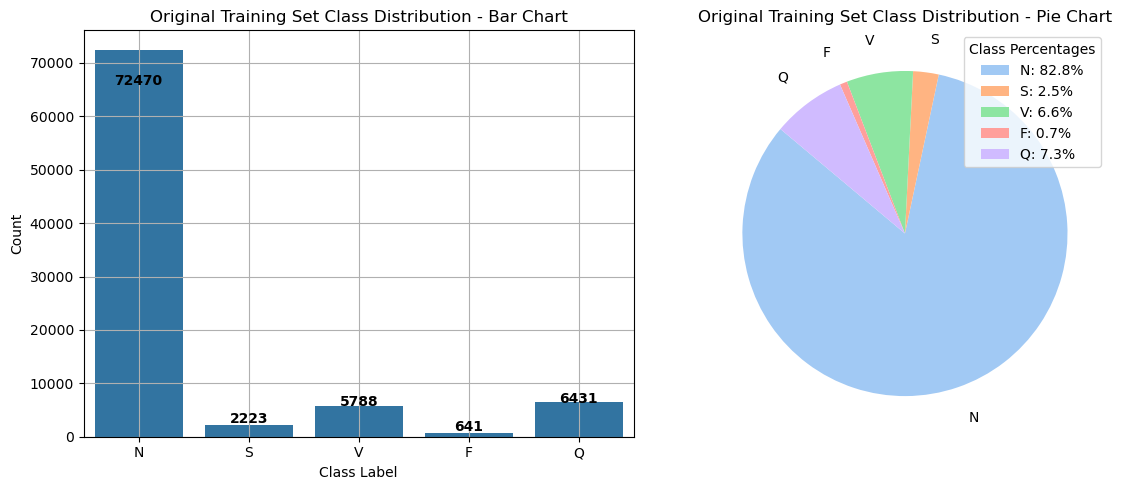

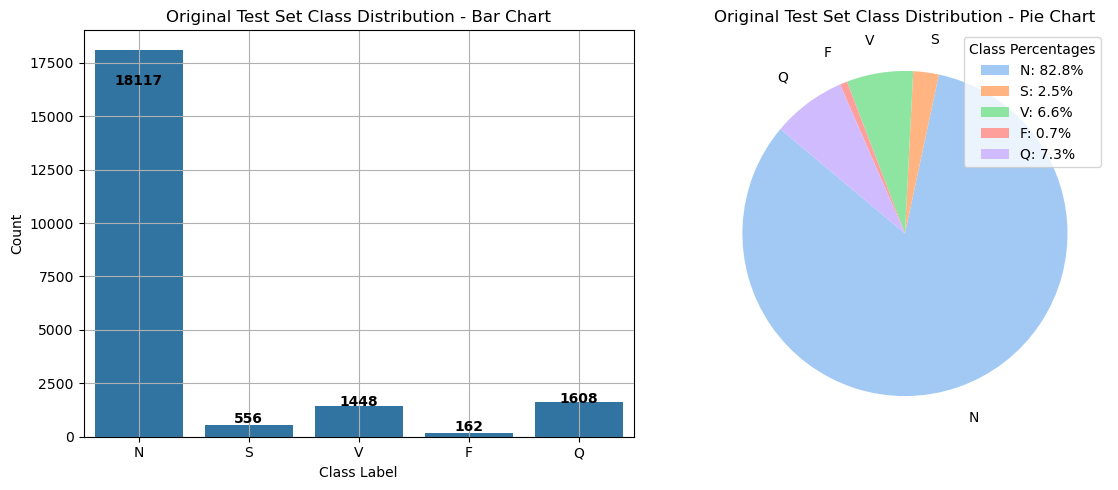

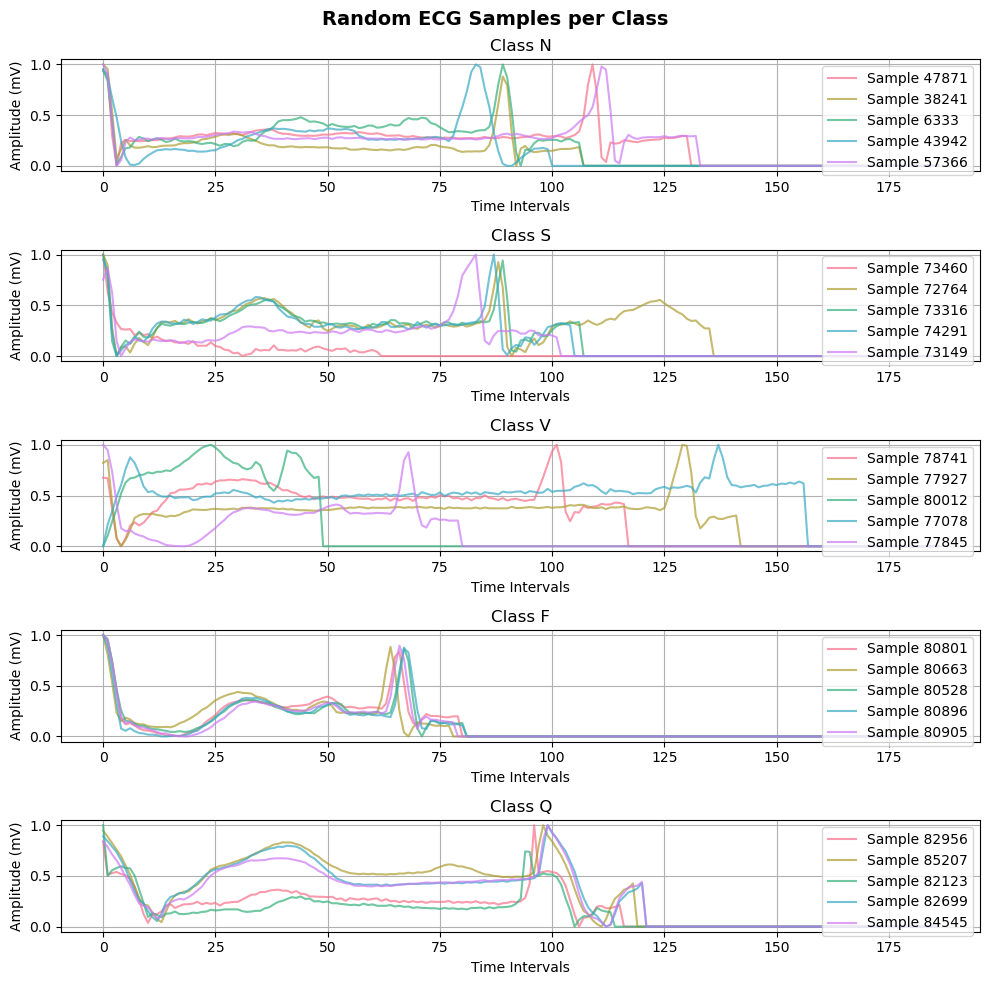

Training set shape: (87553, 187)
Test set shape: (21891, 187)
Mean of the training set: 0.17428381903722243
Standard deviation of the training set: 0.22632775223268004
Mean of the test set: 0.17348341174438647
Standard deviation of the test set: 0.22555486737135405
Normalizing...
Mean of the training set: -6.2910877924933676e-18
Standard deviation of the training set: 0.9999999999999996
Mean of the test set: -0.0048189762427282195
Standard deviation of the test set: 0.9945598777157036
Unique classes in balanced training set: (array([0., 1., 2., 3., 4.]), array([36235, 36235, 36235, 36235, 36235]))


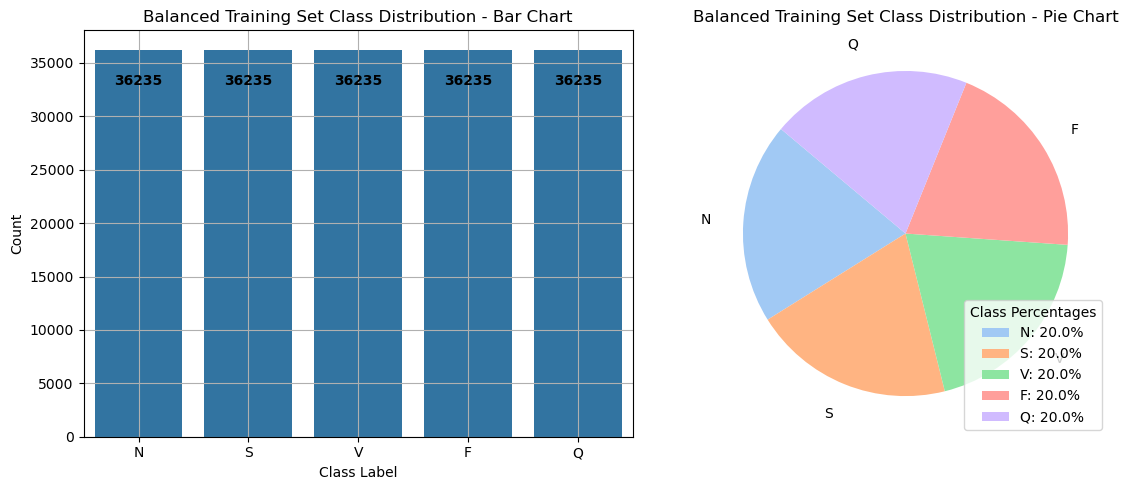


Splitting the training set into training and validation sets...
Unique classes in training set: (array([0., 1., 2., 3., 4.]), array([29061, 28985, 29066, 28802, 29026]))
Unique classes in validation set: (array([0., 1., 2., 3., 4.]), array([7174, 7250, 7169, 7433, 7209]))


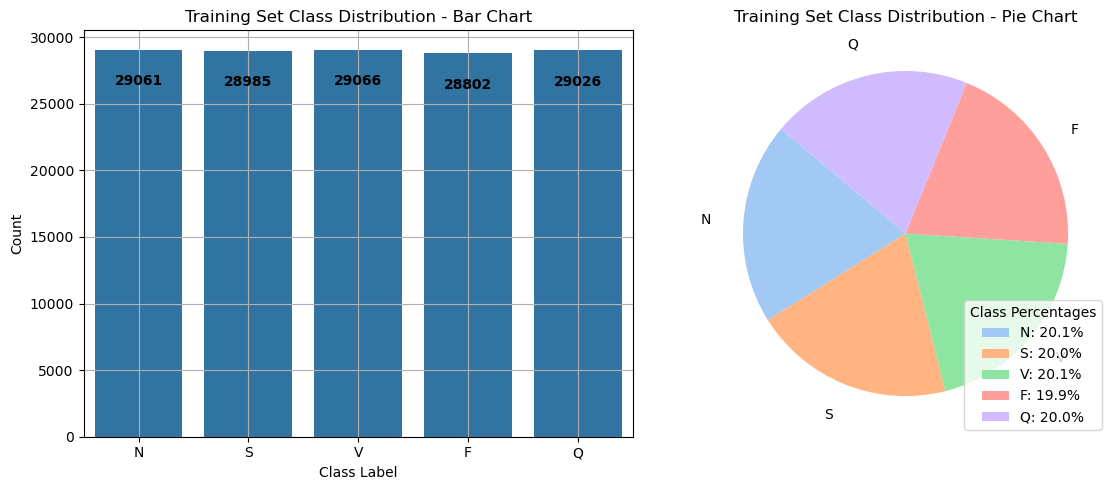

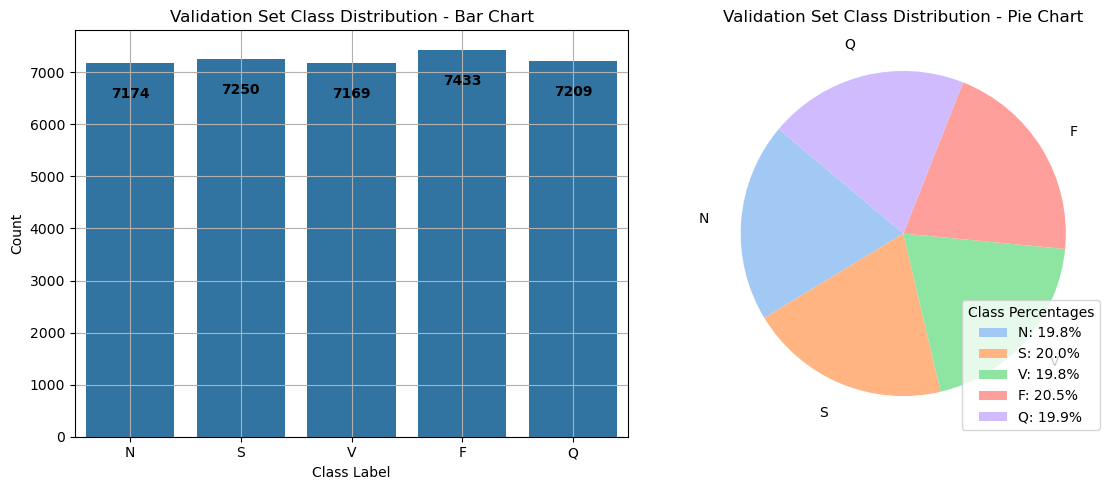

In [2]:
print("Loading and preprocessing the dataset...")
x_train, y_train, x_test, y_test = load_and_preprocess_data("dataset/mitbih_train.csv", "dataset/mitbih_test.csv")

print("\nSplitting the training set into training and validation sets...")
# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Unique classes in training set: {np.unique(y_train, return_counts=True)}")
print(f"Unique classes in validation set: {np.unique(y_val, return_counts=True)}")

# Plot the class distributions
plot_class_distribution(y_train, "Training Set Class Distribution")
plot_class_distribution(y_val, "Validation Set Class Distribution")


In [3]:
# Convert target labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Create and Train Models

### Iteration 1

In [ ]:
cnn_model_it1 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),

    Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer

    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),

    Dense(5, activation='softmax')  # Output layer with 5 classes
])

cnn_model_it1.name = "CNN_Model_Iteration_1"

# Compile the model
cnn_model_it1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model_it1 = train_model(cnn_model_it1, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_model_it1, x_test, y_test)

# Cell run for 8min 4.4s

Model: "CNN_Model_Iteration_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 93, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,765 (866.27 KB)

 Trainable params: 221,765 (866.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.8622 - loss: 0.3849 - val_accuracy: 0.9733 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9656 - loss: 0.0980 - val_accuracy: 0.9842 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9785 - loss: 0.0619 - val_accuracy: 0.9874 - val_loss: 0.0412 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9835 - loss: 0.0488 - val_accuracy: 0.9922 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9870 - loss: 0.0406 - val_accuracy: 0.9930 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9894 - loss: 0.0325 - val_accuracy: 0.9945 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9

In [ ]:
cnn_lstm_model_it1 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),

    LSTM(64, return_sequences=True),

    Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer
    
    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),

    Dense(num_classes, activation='softmax')  # Output layer with 5 classes
])

cnn_lstm_model_it1.name = "CNN_LSTM_Model_Iteration_1"

# Compile the model
cnn_lstm_model_it1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model_it1 = train_model(cnn_lstm_model_it1, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_lstm_model_it1, x_test, y_test)

# Cell run for 94min 4.9s

Model: "CNN_LSTM_Model_Iteration_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 93, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 23, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,965 (691.27 KB)

 Trainable params: 176,965 (691.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 56s 12ms/step - accuracy: 0.8366 - loss: 0.4251 - val_accuracy: 0.9629 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 52s 11ms/step - accuracy: 0.9642 - loss: 0.1041 - val_accuracy: 0.9797 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 948s 209ms/step - accuracy: 0.9780 - loss: 0.0653 - val_accuracy: 0.9871 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 53s 12ms/step - accuracy: 0.9836 - loss: 0.0497 - val_accuracy: 0.9884 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1051s 232ms/step - accuracy: 0.9882 - loss: 0.0375 - val_accuracy: 0.9908 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9899 - loss: 0.0316 - val_accuracy: 0.9891 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step - a

In [ ]:
# GRU model
cnn_gru_model_it1 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),

    GRU(64, return_sequences=True),

    Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),

    Dense(num_classes, activation='softmax')  # Output layer with 5 classes
])

cnn_gru_model_it1.name = "CNN_GRU_Model_Iteration_1"

# Compile the model
cnn_gru_model_it1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_gru_model_it1 = train_model(cnn_gru_model_it1, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_gru_model_it1, x_test, y_test)

# Cell run for 74min 33.7s

Model: "CNN_GRU_Model_Iteration_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 93, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 23, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        94,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,805 (643.77 KB)

 Trainable params: 164,805 (643.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 424s 93ms/step - accuracy: 0.8598 - loss: 0.3741 - val_accuracy: 0.9663 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - accuracy: 0.9647 - loss: 0.0989 - val_accuracy: 0.9829 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 57s 13ms/step - accuracy: 0.9781 - loss: 0.0634 - val_accuracy: 0.9879 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - accuracy: 0.9836 - loss: 0.0498 - val_accuracy: 0.9914 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9861 - loss: 0.0410 - val_accuracy: 0.9927 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.9891 - loss: 0.0332 - val_accuracy: 0.9932 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accur

In [ ]:
print("Iteration 1 Training Complete!")
# Print all model results
for model_name, results in model_results.items():
    print(f"\n\n{model_name} Results:")
    print(f"Training Time: {results['training_time']:.2f} seconds")

    print(f"Metrics: {results['metrics']}")

# Save the model results
save_model_results("model_results_Iteration_1.pkl")

Iteration 1 Training Complete!


CNN_Model_Iteration_1 Results:
Training Time: 483.11 seconds
Training time: 8.05 minutes (3.11 seconds)
Metrics: {'accuracy': 0.9836462473162487, 'precision': 0.9836188734324762, 'recall': 0.9836462473162487, 'f1_score': 0.9836191699369036, 'roc_auc': np.float64(0.9892307124140469)}


CNN_LSTM_Model_Iteration_1 Results:
Training Time: 5642.51 seconds
Training time: 94.04 minutes (2.51 seconds)
Metrics: {'accuracy': 0.9820017358731898, 'precision': 0.9827199721860415, 'recall': 0.9820017358731898, 'f1_score': 0.9822926350409579, 'roc_auc': np.float64(0.9918780112021054)}


CNN_GRU_Model_Iteration_1 Results:
Training Time: 4471.46 seconds
Training time: 74.52 minutes (31.46 seconds)
Metrics: {'accuracy': 0.9835548855694121, 'precision': 0.9836319008660352, 'recall': 0.9835548855694121, 'f1_score': 0.9835845776367935, 'roc_auc': np.float64(0.9922429967150578)}


In [31]:
# Load the saved models and evaluate them
cnn_model_it1 = load_model("training-models/CNN_Model_Iteration_1.keras")
cnn_lstm_model_it1 = load_model("training-models/CNN_LSTM_Model_Iteration_1.keras")
cnn_gru_model_it1 = load_model("training-models/CNN_GRU_Model_Iteration_1.keras")

# Evaluate the models
evaluate_model(cnn_model_it1, x_test, y_test)
evaluate_model(cnn_lstm_model_it1, x_test, y_test)
evaluate_model(cnn_gru_model_it1, x_test, y_test)

# Save the model results
save_model_results("model_results_Iteration_1.pkl")

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Performance metrics for CNN_Model_Iteration_1:
              precision    recall  f1-score   support

           0     0.9914    0.9912    0.9913     18117
           1     0.8451    0.8147    0.8297       556
           2     0.9547    0.9613    0.9580      1448
           3     0.7965    0.8457    0.8204       162
           4     0.9888    0.9913    0.9901      1608

    accuracy                         0.9836     21891
   macro avg     0.9153    0.9208    0.9179     21891
weighted avg     0.9836    0.9836    0.9836     21891

Confusion Matrix:
[[17957    81    46    17    16]
 [   95   453     7     0     1]
 [   36     1  1392    18     1]
 [   13     0    12   137     0]
 [   12     1     1     0  1594]]
Confusion Matrix with Percentages:
[[9.91168516e-01 4.47093890e-03 2.53905172e-03 9.38345201e-04
  8.83148424e-04]
 [1.70863309e-01 8.14748201e-01 1.25899281e-02 0.00000000e+00
  1.79856115e-03]
 [2.48618785e-02 6.90607735e-04 9.61325967e-

### Iteration 2 (Add Residual Blocks)

In [8]:
def residual_block(x, filters, kernel_size=3, downsample=False):
    """
    Creates a residual block with two Conv1D layers.
    Args:
      x: Input tensor to the residual block.
      filters: Number of Conv1D filters in this block.
      kernel_size: Convolution kernel size.
      downsample: If True, downsample the spatial dimension (stride=2) for this block.
    Returns:
      Output tensor of the residual block.
    """
    # Save the input tensor for the shortcut path
    shortcut = x

    # First convolution layer (with optional downsampling)
    y = Conv1D(filters, kernel_size, padding='same',
               strides=(2 if downsample else 1), kernel_initializer='he_normal')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Second convolution layer (always stride 1)
    y = Conv1D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization()(y)
    # (No activation here yet; we'll add after combining with shortcut)

    # Shortcut path to match dimensions
    if downsample or x.shape[-1] != filters:
        # If we downsampled or filter count changed, adjust shortcut path
        shortcut = Conv1D(filters, kernel_size=1, padding='same',
                          strides=(2 if downsample else 1), kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut and main path
    y = Add()([shortcut, y])
    y = Activation('relu')(y)  # Activation after adding the residual
    return y

In [ ]:
input_shape = (x_train.shape[1], 1)  # Shape of input data (excluding batch dimension)
inputs = Input(shape=input_shape)

# Residual Block 1
x = residual_block(inputs, filters=32, kernel_size=3, downsample=False)
# Residual Block 2
x = residual_block(x, filters=64, kernel_size=3, downsample=True)
# Residual Block 3
x = residual_block(x, filters=128, kernel_size=3, downsample=True)

x = Flatten()(x) # Flatten the 3D output to 1D tensor to be used in the dense layer

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)  # use the actual number of classes in your dataset

cnn_model_it2 = Model(inputs, outputs, name="CNN_Model_Iteration_2")

# Compile the model
cnn_model_it2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model_it2 = train_model(cnn_model_it2, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_model_it2, x_test, y_test)

# Cell run for 120min 41.4s

Model: "CNN_Model_Iteration_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 187, 32)   │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 32)   │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 187, 32)   │         64 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 187, 32)   │      3,104 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 187, 32)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 94, 64)    │      6,208 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 94, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 94, 64)    │      2,112 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 94, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 94, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 94, 64)    │          0 │ add_1[0][0]     

 Total params: 496,293 (1.89 MB)

 Trainable params: 494,949 (1.89 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 93s 20ms/step - accuracy: 0.8680 - loss: 0.3589 - val_accuracy: 0.9730 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 89s 20ms/step - accuracy: 0.9669 - loss: 0.0941 - val_accuracy: 0.9877 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.9788 - loss: 0.0608 - val_accuracy: 0.9903 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 93s 21ms/step - accuracy: 0.9853 - loss: 0.0425 - val_accuracy: 0.9926 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.9888 - loss: 0.0341 - val_accuracy: 0.9943 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.9912 - loss: 0.0265 - val_accuracy: 0.9937 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accura

In [ ]:
input_shape = (x_train.shape[1], 1)  # Shape of input data (excluding batch dimension)
inputs = Input(shape=input_shape)

# Residual Block 1
x = residual_block(inputs, filters=32, kernel_size=3, downsample=False)
# Residual Block 2
x = residual_block(x, filters=64, kernel_size=3, downsample=True)
# Residual Block 3
x = residual_block(x, filters=128, kernel_size=3, downsample=True)

# LSTM layer
x = LSTM(64, return_sequences=True)(x)

x = Flatten()(x) # Flatten the 3D output to 1D tensor to be used in the dense layer

x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)  # use the actual number of classes in your dataset

cnn_lstm_model_it2 = Model(inputs, outputs, name="CNN_LSTM_Model_Iteration_2") # Forgot to rename in the run. But handled. Evaluate model should be run again in the end for all three iteration 2 models after they were reloaded.

# Compile the model
cnn_lstm_model_it2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model_it2 = train_model(cnn_lstm_model_it2, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_lstm_model_it2, x_test, y_test)

# Cell run for 259m 55.6s

Model: "CNN_Model_Iteration_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 187, 32)   │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 187, 32)   │         64 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 187, 32)   │      3,104 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 187, 32)   │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 94, 64)    │      6,208 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 94, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 94, 64)    │      2,112 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 94, 64)    │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 94, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 94, 64)    │          0 │ add_4[0][0]     

 Total params: 353,189 (1.35 MB)

 Trainable params: 351,845 (1.34 MB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 150s 33ms/step - accuracy: 0.8917 - loss: 0.3059 - val_accuracy: 0.9782 - val_loss: 0.0619 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 485s 107ms/step - accuracy: 0.9748 - loss: 0.0732 - val_accuracy: 0.9862 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 147s 32ms/step - accuracy: 0.9843 - loss: 0.0474 - val_accuracy: 0.9839 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1082s 239ms/step - accuracy: 0.9880 - loss: 0.0368 - val_accuracy: 0.9940 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1150s 254ms/step - accuracy: 0.9906 - loss: 0.0296 - val_accuracy: 0.9904 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1284s 284ms/step - accuracy: 0.9917 - loss: 0.0250 - val_accuracy: 0.9950 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1704s 376

In [ ]:
input_shape = (x_train.shape[1], 1)  # Shape of input data (excluding batch dimension)
inputs = Input(shape=input_shape)

# Residual Block 1
x = residual_block(inputs, filters=32, kernel_size=3, downsample=False)
# Residual Block 2
x = residual_block(x, filters=64, kernel_size=3, downsample=True)
# Residual Block 3
x = residual_block(x, filters=128, kernel_size=3, downsample=True)

# GRU layers
x = GRU(64)(x)

x = Flatten()(x) # Flatten the 3D output to 1D tensor to be used in the dense layer

# Dense layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(num_classes, activation='softmax')(x)  # use the actual number of classes in your dataset

cnn_gru_model_it2 = Model(inputs, outputs, name="CNN_GRU_Model_Iteration_2")

# Compile the model
cnn_gru_model_it2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_gru_model_it2 = train_model(cnn_gru_model_it2, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_gru_model_it2, x_test, y_test)

# Cell run for 113min 9.3s

Model: "CNN_GRU_Model_Iteration_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 187, 32)   │        128 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 187, 32)   │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 187, 32)   │      3,104 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 187, 32)   │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 94, 64)    │      6,208 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 94, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 94, 64)    │      2,112 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 94, 64)    │     12,352 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 94, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 94, 64)    │          0 │ add_10[0][0]    

 Total params: 152,613 (596.14 KB)

 Trainable params: 151,269 (590.89 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 153s 33ms/step - accuracy: 0.7532 - loss: 0.6067 - val_accuracy: 0.9469 - val_loss: 0.1534 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 152s 34ms/step - accuracy: 0.9522 - loss: 0.1362 - val_accuracy: 0.9720 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 143s 31ms/step - accuracy: 0.9707 - loss: 0.0881 - val_accuracy: 0.9800 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 142s 31ms/step - accuracy: 0.9783 - loss: 0.0643 - val_accuracy: 0.9744 - val_loss: 0.0741 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 135s 30ms/step - accuracy: 0.9826 - loss: 0.0544 - val_accuracy: 0.9836 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - accuracy: 0.9865 - loss: 0.0431 - val_accuracy: 0.9881 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 1448s 320ms/step

In [32]:
# Load the saved models from iteration 2 and reavaluate them
cnn_model_it2 = load_saved_model("training-models/CNN_Model_Iteration_2.keras")
cnn_lstm_model_it2 = load_saved_model("training-models/CNN_LSTM_Model_Iteration_2.keras")
cnn_gru_model_it2 = load_saved_model("training-models/CNN_GRU_Model_Iteration_2.keras")

# Evaluate the models
evaluate_model(cnn_model_it2, x_test, y_test)
evaluate_model(cnn_lstm_model_it2, x_test, y_test)
evaluate_model(cnn_gru_model_it2, x_test, y_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Performance metrics for CNN_Model_Iteration_2:
              precision    recall  f1-score   support

           0     0.9929    0.9880    0.9905     18117
           1     0.8163    0.8309    0.8235       556
           2     0.9319    0.9634    0.9474      1448
           3     0.7405    0.8457    0.7896       162
           4     0.9851    0.9894    0.9873      1608

    accuracy                         0.9815     21891
   macro avg     0.8933    0.9235    0.9077     21891
weighted avg     0.9819    0.9815    0.9816     21891

Confusion Matrix:
[[17900   100    75    22    20]
 [   82   462    11     1     0]
 [   24     1  1395    24     4]
 [    9     2    14   137     0]
 [   13     1     2     1  1591]]
Confusion Matrix with Percentages:
[[9.88022299e-01 5.51967765e-03 4.13975824e-03 1.21432908e-03
  1.10393553e-03]
 [1.47482014e-01 8.30935252e-01 1.97841727e-02 1.79856115e-03
  0.00000000e+00]
 [1.65745856e-02 6.90607735e-04 9.63397790e-

In [ ]:
print("Iteration 2 Training Complete!")
# Print all model results
for model_name, results in model_results.items():
    print(f"\n\n{model_name} Results:")
    print(f"Training Time: {results['training_time']:.2f} seconds")
    print(f"Training time: {results['training_time'] / 60:.2f} minutes ({results['training_time'] % 60:.2f} seconds)")
    print(f"Metrics: {results['metrics']}")

# Save the model results
save_model_results("model_results_Iteration_2.pkl")

### Iteration 3 (Switch Dense Layers with GlobalAveragePoolin1D)

In [ ]:
cnn_model_it3 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),

    Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer

    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),

    Dense(5, activation='softmax')  # Output layer with 5 classes
])

cnn_model_it3 = Model(inputs, outputs, name="CNN_Model_Iteration_3")

# Compile the model
cnn_model_it3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model_it3 = train_model(cnn_model_it3, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_model_it3, x_test, y_test)

# Cell run for 34min 33.9s

Model: "CNN_Model_Iteration_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 187, 32)   │        128 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 187, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 187, 32)   │         64 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 187, 32)   │      3,104 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 187, 32)   │        128 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 187, 32)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 187, 32)   │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 94, 64)    │      6,208 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 94, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 94, 64)    │      2,112 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 94, 64)    │     12,352 │ activation_20[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 64)    │        256 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 94, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 94, 64)    │          0 │ add_10[0][0]    

 Total params: 152,613 (596.14 KB)

 Trainable params: 151,269 (590.89 KB)

 Non-trainable params: 1,344 (5.25 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 139s 30ms/step - accuracy: 0.9960 - loss: 0.0140 - val_accuracy: 0.9909 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 144s 32ms/step - accuracy: 0.9954 - loss: 0.0158 - val_accuracy: 0.9946 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - accuracy: 0.9957 - loss: 0.0136 - val_accuracy: 0.9933 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 130s 29ms/step - accuracy: 0.9955 - loss: 0.0146 - val_accuracy: 0.9936 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 127s 28ms/step - accuracy: 0.9957 - loss: 0.0144 - val_accuracy: 0.9958 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 129s 28ms/step - accuracy: 0.9956 - loss: 0.0131 - val_accuracy: 0.9877 - val_loss: 0.0399 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 127s 28ms/step -

In [ ]:
cnn_lstm_model_it3 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPool1D(pool_size=2),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),

    #Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer
    GlobalAveragePooling1D(),
    
    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')  # Output layer with 5 classes
])

cnn_lstm_model_it3.name = "CNN_LSTM_Model_Iteration_3"

# Compile the model
cnn_lstm_model_it3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_lstm_model_it3 = train_model(cnn_lstm_model_it3, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_lstm_model_it3, x_test, y_test)

# Cell run for 28min 20.7s

Model: "CNN_LSTM_Model_Iteration_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 93, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 93, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 23, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,349 (567.77 KB)

 Trainable params: 144,901 (566.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.8559 - loss: 0.4103 - val_accuracy: 0.9613 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9632 - loss: 0.1116 - val_accuracy: 0.9774 - val_loss: 0.0661 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - accuracy: 0.9765 - loss: 0.0720 - val_accuracy: 0.9804 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - accuracy: 0.9831 - loss: 0.0557 - val_accuracy: 0.9861 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.9861 - loss: 0.0438 - val_accuracy: 0.9879 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - accuracy: 0.9894 - loss: 0.0352 - val_accuracy: 0.9911 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 85s 19ms/step - accura

In [ ]:
# GRU model
cnn_gru_model_it3 = Sequential([
    Input(shape=(x_train.shape[1], 1)),  # Input layer with the same shape as x_train
    
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool1D(pool_size=2),

    Bidirectional(GRU(64, return_sequences=True)),

    #Flatten(),  # Flatten the 3D output to 1D tensor to be used in the dense layer
    GlobalAveragePooling1D(), 

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')  # Output layer with 5 classes
])

cnn_gru_model_it3.name = "CNN_GRU_Model_Iteration_3"

# Compile the model
cnn_gru_model_it3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_gru_model_it3 = train_model(cnn_gru_model_it3, x_train, y_train, x_val, y_val, epochs=20, batch_size=32)

# Evaluate the model
evaluate_model(cnn_gru_model_it3, x_test, y_test)

# Cell run for 30min 50.9s

Model: "CNN_GRU_Model_Iteration_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 187, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 93, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 23, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,029 (472.77 KB)

 Trainable params: 120,581 (471.02 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 97s 21ms/step - accuracy: 0.8434 - loss: 0.4277 - val_accuracy: 0.9558 - val_loss: 0.1219 - learning_rate: 0.0010
Epoch 2/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.9606 - loss: 0.1202 - val_accuracy: 0.9757 - val_loss: 0.0681 - learning_rate: 0.0010
Epoch 3/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.9744 - loss: 0.0776 - val_accuracy: 0.9854 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 4/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 91s 20ms/step - accuracy: 0.9815 - loss: 0.0579 - val_accuracy: 0.9868 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 5/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.9853 - loss: 0.0478 - val_accuracy: 0.9842 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 6/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 94s 21ms/step - accuracy: 0.9865 - loss: 0.0431 - val_accuracy: 0.9884 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 7/20
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 101s 22ms/step - accur

In [47]:
# Load and evaluate the saved models
cnn_model_it3 = load_saved_model("training-models/CNN_Model_Iteration_3.keras")
cnn_lstm_model_it3 = load_saved_model("training-models/CNN_LSTM_Model_Iteration_3.keras")
cnn_gru_model_it3 = load_saved_model("training-models/CNN_GRU_Model_Iteration_3.keras")

# Evaluate the models
evaluate_model(cnn_model_it3, x_test, y_test)
evaluate_model(cnn_lstm_model_it3, x_test, y_test)
evaluate_model(cnn_gru_model_it3, x_test, y_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Performance metrics for CNN_Model_Iteration_3:
              precision    recall  f1-score   support

           0     0.9921    0.9860    0.9891     18117
           1     0.7439    0.8255    0.7826       556
           2     0.9329    0.9599    0.9462      1448
           3     0.8025    0.7778    0.7900       162
           4     0.9790    0.9869    0.9830      1608

    accuracy                         0.9788     21891
   macro avg     0.8901    0.9072    0.8982     21891
weighted avg     0.9795    0.9788    0.9791     21891

Confusion Matrix:
[[17864   147    69    10    27]
 [   87   459     8     2     0]
 [   26     6  1390    19     7]
 [   16     0    20   126     0]
 [   13     5     3     0  1587]]
Confusion Matrix with Percentages:
[[9.86035216e-01 8.11392615e-03 3.80857758e-03 5.51967765e-04
  1.49031297e-03]
 [1.56474820e-01 8.25539568e-01 1.43884892e-02 3.59712230e-03
  0.00000000e+00]
 [1.79558011e-02 4.14364641e-03 9.59944751e-

In [48]:
print("Iteration 3 Training Complete!")
# Print all model results
for model_name, results in model_results.items():
    print(f"\n\n{model_name} Results:")
    print(f"Training Time: {results['training_time']:.2f} seconds")
    print(f"Metrics: {results['metrics']}")

# Save the model results
save_model_results("model_results_Iteration_3.pkl")

Iteration 3 Training Complete!
